## Project Overview
Pada proyek ini, kita akan membangun sistem rekomendasi buku menggunakan pendekatan Collaborative Filtering. Dataset yang digunakan adalah [Book Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Ratings.csv) dari Kaggle yang berisi informasi buku, pengguna, dan rating yang diberikan pengguna terhadap buku.

Tujuan utama dari proyek ini adalah merekomendasikan buku berdasarkan riwayat interaksi pengguna sebelumnya.


## Business Understanding

Kembangkan sebuah sistem rekomendasi buku untuk menjawab permasalahan berikut:

- Bagaimana membangun sistem rekomendasi buku yang dipersonalisasi menggunakan teknik collaborative filtering berbasis deep learning?

- Bagaimana sistem dapat memprediksi dan merekomendasikan buku lain yang kemungkinan besar disukai pengguna berdasarkan data rating sebelumnya?

- Bagaimana sistem ini dapat memberikan nilai tambah bagi pengguna dalam menemukan buku-buku yang belum pernah mereka baca sebelumnya?

Untuk menjawab pertanyaan tersebut, sistem rekomendasi ini dikembangkan dengan tujuan atau goals sebagai berikut:

- Menghasilkan rekomendasi buku yang dipersonalisasi untuk setiap pengguna berdasarkan pola interaksi dan rating historis.

- Membangun model rekomendasi menggunakan pendekatan embedding neural network untuk collaborative filtering.

- Menyediakan prediksi rating yang akurat sebagai dasar pengambilan keputusan dalam sistem rekomendasi.



# Data Understanding

Menginstal library penting yang digunakan untuk pemrosesan numerik, machine learning, dan rekomendasi.

In [1]:
!pip install numpy==1.23.5
!pip install tensorflow==2.12
!pip install jax==0.4.6 jaxlib==0.4.6
!pip install scikit-surprise

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorboard-2.12.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached wrapt-1.14.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
  Using cached jax-0.6.1-py3-none-any.whl.metadata (13 kB)
  Using cached jaxlib-0.6.1-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata

Menginstal CLI untuk mengakses dataset dari Kaggle.

In [2]:
!pip install -q kaggle

Mengunggah token API Kaggle untuk mengakses data,  serta mengunduh dan mengekstrak dataset dari Kaggle.

In [3]:
from google.colab import files

# Mengupload file kaggle.json dari komputer lokal
files.upload()

import os
import shutil

os.makedirs('/root/.kaggle', exist_ok=True)

shutil.copy('kaggle.json', '/root/.kaggle/kaggle.json')

os.chmod('/root/.kaggle/kaggle.json', 600)

# Download dataset Book Recommendation
!kaggle datasets download -d arashnic/book-recommendation-dataset

# Ekstrak file zip
import zipfile

with zipfile.ZipFile("book-recommendation-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("book_data")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
  0% 0.00/24.3M [00:00<?, ?B/s]
100% 24.3M/24.3M [00:00<00:00, 1.14GB/s]


Membaca ketiga file CSV utama ke DataFrame.

In [4]:
# Load data
import pandas as pd

books = pd.read_csv('book_data/Books.csv', encoding='latin-1')
users = pd.read_csv('book_data/Users.csv', encoding='latin-1')
ratings = pd.read_csv('book_data/Ratings.csv', encoding='latin-1')

<ipython-input-4-484ff97601e5>:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('book_data/Books.csv', encoding='latin-1')


Menampilkan informasi struktur DataFrame.

In [5]:
# Tampilkan info dasar
print("Books")
print(books.info())
print("\nUsers")
print(users.info())
print("\nRatings")
print(ratings.info())

Books
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None

Users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), i

Menyajikan informasi mengenai ukuran dataset.

In [6]:
print('Jumlah data buku: ', len(books.ISBN.unique()))
print('Jumlah data user: ', len(users['User-ID'].unique()))
print('Jumlah data rating: ', len(ratings))
print('Jumlah rating eksplisit (rating > 0): ', len(ratings[ratings['Book-Rating'] > 0]))
print('Jumlah rating implisit (rating == 0): ', len(ratings[ratings['Book-Rating'] == 0]))

Jumlah data buku:  271360
Jumlah data user:  278858
Jumlah data rating:  1149780
Jumlah rating eksplisit (rating > 0):  433671
Jumlah rating implisit (rating == 0):  716109


# Univariate Exploratory Data Analysis

Variabel-variabel pada RBook Recommendation Dataset dataset adalah sebagai berikut:
- Books : merupakan data mengenai buku yang mencakup ISBN, judul buku, penulis, tahun terbit, dan nama penerbit.

- Users : merupakan data mengenai pengguna yang terdiri dari User-ID, lokasi (negara/kota), dan usia pengguna.

- Ratings : merupakan data interaksi antara pengguna dan buku, berupa rating yang diberikan pengguna terhadap suatu buku dengan skala 0–10.

## Books

Menampilkan struktur dan ringkasan dataframe books, seperti jumlah entri, tipe data kolom, jumlah non-null

In [7]:
print(books.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None


Memuat tiga dataset (Books.csv, Users.csv, Ratings.csv) dan:

- Mengonversi kolom Year-Of-Publication menjadi numerik (menghindari string seperti 'DK Pub').

- Menampilkan informasi ringkas (info()) dari ketiga dataset untuk verifikasi awal bentuk dan isi.

In [8]:
# Load data
import pandas as pd

books = pd.read_csv('book_data/Books.csv', encoding='latin-1')
users = pd.read_csv('book_data/Users.csv', encoding='latin-1')
ratings = pd.read_csv('book_data/Ratings.csv', encoding='latin-1')

# Bersihkan Year-Of-Publication
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

# Tampilkan info dasar
print("Books")
print(books.info())
print("\nUsers")
print(users.info())
print("\nRatings")
print(ratings.info())

<ipython-input-8-6adb442d595b>:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('book_data/Books.csv', encoding='latin-1')


Books
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271360 non-null  object 
 1   Book-Title           271360 non-null  object 
 2   Book-Author          271358 non-null  object 
 3   Year-Of-Publication  271357 non-null  float64
 4   Publisher            271358 non-null  object 
 5   Image-URL-S          271360 non-null  object 
 6   Image-URL-M          271360 non-null  object 
 7   Image-URL-L          271357 non-null  object 
dtypes: float64(1), object(7)
memory usage: 16.6+ MB
None

Users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64

## Users

Menampilkan info struktur dataframe users.

In [9]:
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None


Menampilkan jumlah user unik dan statistik ringkasan kolom Age (rata-rata, min, max, dsb).

In [10]:
print('Jumlah user unik: ', len(users['User-ID'].unique()))
print('Usia pengguna - Statistik deskriptif:')
print(users['Age'].describe())

Jumlah user unik:  278858
Usia pengguna - Statistik deskriptif:
count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64


## Ratings

Menampilkan struktur dataframe ratings.

In [11]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None


Menampilkan 5 baris pertama data rating untuk melihat format data.

In [12]:
print('Contoh rating:')
print(ratings.head())

Contoh rating:
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6


Menampilkan jumlah user dan ISBN unik dan menampilkan distribusi frekuensi dari nilai Book-Rating.

In [13]:
print('Jumlah user unik: ', len(ratings['User-ID'].unique()))
print('Jumlah ISBN unik: ', len(ratings['ISBN'].unique()))
print('Distribusi rating:')
print(ratings['Book-Rating'].value_counts().sort_index())

Jumlah user unik:  105283
Jumlah ISBN unik:  340556
Distribusi rating:
Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64


Visualisasi dari:
- Distribusi Rating Buku
- Top 20 User dengan Jumlah Rating Terbanyak
- Top 20 Buku yang Paling Banyak Dirating
- Distribusi Usia Pengguna

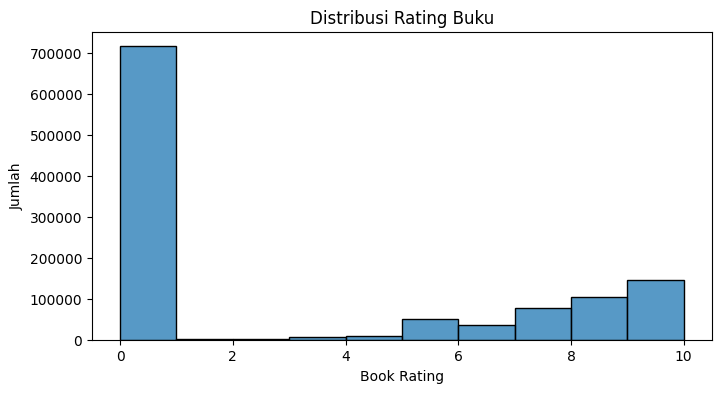

<ipython-input-14-0f423f9a9130>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_counts.index.astype(str), y=user_counts.values, palette='Blues_d')


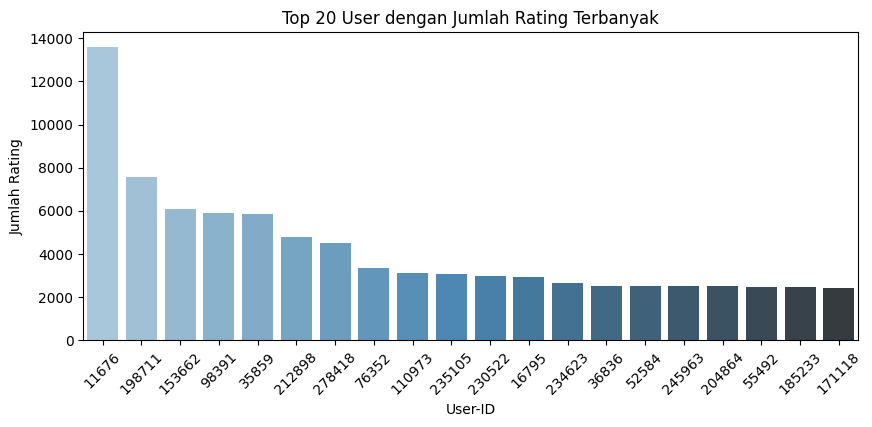

<ipython-input-14-0f423f9a9130>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=book_counts.index, y=book_counts.values, palette='Greens_d')


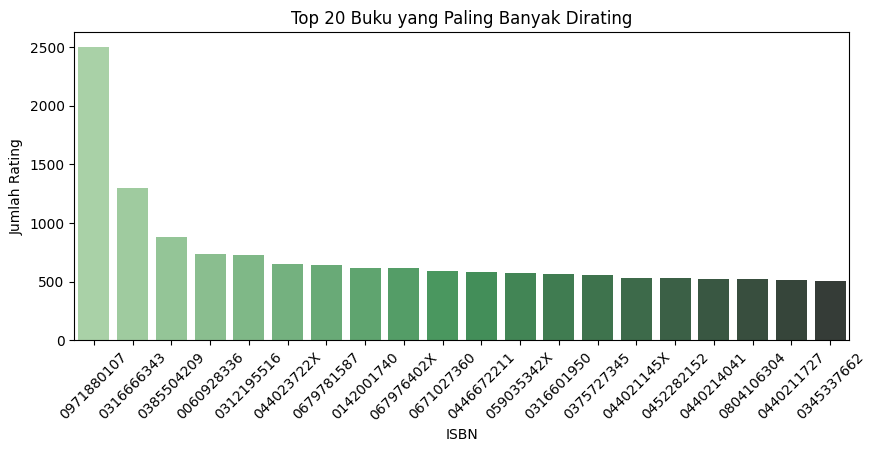

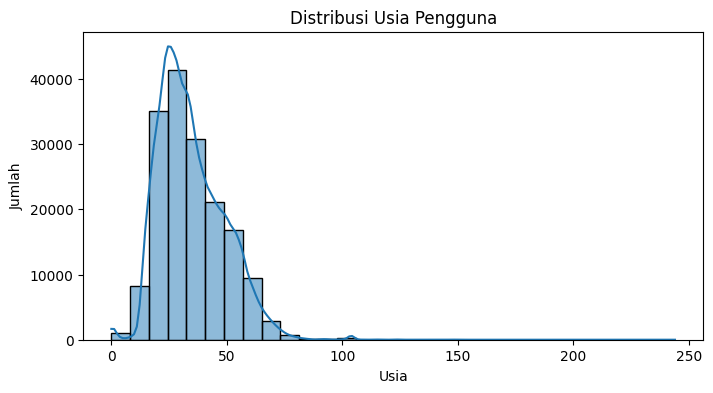

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi Book Rating
plt.figure(figsize=(8, 4))
sns.histplot(ratings['Book-Rating'], bins=10, kde=False)
plt.title('Distribusi Rating Buku')
plt.xlabel('Book Rating')
plt.ylabel('Jumlah')
plt.show()

# Jumlah interaksi per user (Top 20)
user_counts = ratings['User-ID'].value_counts().head(20)
plt.figure(figsize=(10, 4))
sns.barplot(x=user_counts.index.astype(str), y=user_counts.values, palette='Blues_d')
plt.title('Top 20 User dengan Jumlah Rating Terbanyak')
plt.xlabel('User-ID')
plt.ylabel('Jumlah Rating')
plt.xticks(rotation=45)
plt.show()

# Jumlah interaksi per buku (Top 20)
book_counts = ratings['ISBN'].value_counts().head(20)
plt.figure(figsize=(10, 4))
sns.barplot(x=book_counts.index, y=book_counts.values, palette='Greens_d')
plt.title('Top 20 Buku yang Paling Banyak Dirating')
plt.xlabel('ISBN')
plt.ylabel('Jumlah Rating')
plt.xticks(rotation=45)
plt.show()

# Distribusi usia pengguna
plt.figure(figsize=(8, 4))
sns.histplot(users['Age'], bins=30, kde=True)
plt.title('Distribusi Usia Pengguna')
plt.xlabel('Usia')
plt.ylabel('Jumlah')
plt.show()

# Data Preprocessing

## Cleaning Data Awal

Pada tahap ini dilakukan inisialisasi proses pembersihan data, seperti mengonversi kolom numerik dan memfilter data tidak valid sebagai langkah awal.
Proses pembersihan lanjutan secara menyeluruh akan dijelaskan dan diterapkan pada tahap Data Preparation.

In [15]:
# Contoh awal cleaning data

# Konversi kolom 'Year-Of-Publication' menjadi numerik
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

# Filter user dengan usia antara 5 hingga 100 tahun
users = users[(users['Age'] >= 5) & (users['Age'] <= 100)]

# Tampilkan missing value sebagai acuan pembersihan awal
print("Missing value pada books:")
print(books.isnull().sum())

Missing value pada books:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    3
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


# Data Preparation

## Mengecek & Mengatasi Missing Value

Menampilkan jumlah nilai kosong (NaN) pada setiap kolom di ketiga dataframe (books, users, ratings) setelah proses filter awal.

In [16]:
# Cek missing value pada dataset
print("Missing value pada books:")
print(books.isnull().sum())
print("\nMissing value pada users:")
print(users.isnull().sum())
print("\nMissing value pada ratings:")
print(ratings.isnull().sum())

Missing value pada books:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    3
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Missing value pada users:
User-ID     0
Location    0
Age         0
dtype: int64

Missing value pada ratings:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


Menghapus missing values dan membuat salinan data bersih (books_clean, users_clean, ratings_clean). Menampilkan kembali jumlah missing values setelah dibersihkan.

In [17]:
# Hapus missing value dari semua dataframe
books_clean = books.dropna()
users_clean = users.dropna()
ratings_clean = ratings.dropna()

# Cek ulang
print("Setelah dibersihkan:")
print("Books:", books_clean.isnull().sum().sum())
print("Users:", users_clean.isnull().sum().sum())
print("Ratings:", ratings_clean.isnull().sum().sum())

Setelah dibersihkan:
Books: 0
Users: 0
Ratings: 0


Memastikan kembali bahwa data benar-benar bebas dari nilai kosong.

In [18]:
# Mengecek kembali missing value pada dataset yang sudah dibersihkan
print("Missing value pada books_clean:")
print(books_clean.isnull().sum())

print("\nMissing value pada users_clean:")
print(users_clean.isnull().sum())

print("\nMissing value pada ratings_clean:")
print(ratings_clean.isnull().sum())

Missing value pada books_clean:
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

Missing value pada users_clean:
User-ID     0
Location    0
Age         0
dtype: int64

Missing value pada ratings_clean:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


## Membersihkan & Memfilter Data yang Tidak Valid

Bersihkan Ulang Tahun & Usia
- Validasi ulang kolom Year-Of-Publication agar berada dalam range wajar (1800–2025).

- Memfilter ulang kolom Age agar hanya dalam 5–100 tahun.

In [19]:
# Bersihkan kolom tahun publikasi
books_clean['Year-Of-Publication'] = pd.to_numeric(books_clean['Year-Of-Publication'], errors='coerce')
books_clean = books_clean[(books_clean['Year-Of-Publication'] >= 1800) & (books_clean['Year-Of-Publication'] <= 2025)]

# Filter usia user yang valid
users_clean = users_clean[(users_clean['Age'] >= 5) & (users_clean['Age'] <= 100)]

<ipython-input-19-15472961d627>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_clean['Year-Of-Publication'] = pd.to_numeric(books_clean['Year-Of-Publication'], errors='coerce')


## Menyaring Data Aktif (User & Buku yang Sering Digunakan)

Filter ulang dataset bersih agar hanya menyertakan user dan buku dengan ≥10 interaksi (agar model nanti lebih andal).

In [20]:
# Hanya ambil user dan buku yang punya setidaknya 10 interaksi
user_counts = ratings_clean['User-ID'].value_counts()
book_counts = ratings_clean['ISBN'].value_counts()

active_users = user_counts[user_counts >= 10].index
popular_books = book_counts[book_counts >= 10].index

ratings_filtered = ratings_clean[
    (ratings_clean['User-ID'].isin(active_users)) &
    (ratings_clean['ISBN'].isin(popular_books))
]

## Menyusun Dataframe Final untuk Modeling

- Menggabungkan ratings_filtered dengan books_clean berdasarkan ISBN.

- Menghapus baris hasil merge yang tidak memiliki Book-Title.

- Menampilkan ukuran data hasil merge sebelum dan sesudah dibersihkan.

In [21]:
# Gabung ratings data dan book information
all_book_info = pd.merge(ratings_filtered, books_clean, on='ISBN')

all_book_info_clean = all_book_info.dropna(subset=['Book-Title'])

print(f"Original merged data shape: {all_book_info.shape}")
print(f"Cleaned merged data shape: {all_book_info_clean.shape}")

Original merged data shape: (427637, 10)
Cleaned merged data shape: (427637, 10)


## Menyiapkan Data untuk Model Collaborative Filtering

- Menginstal library scikit-surprise untuk membangun sistem rekomendasi.

- Mengimpor Dataset dan Reader dari Surprise.

- Membentuk dataset Surprise dari ratings_filtered.

- Verifikasi bahwa dataset berhasil dibuat.



In [22]:
!pip install scikit-surprise

# Import surprise
from surprise import Dataset, Reader

# Format data untuk Surprise
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(ratings_filtered[['User-ID', 'ISBN', 'Book-Rating']], reader)

# Cek berhasil
print("Surprise dataset loaded successfully.")

Surprise dataset loaded successfully.


# Model Development dengan Collaborative Filtering

- Mengimpor library yang dibutuhkan: pandas dan numpy untuk manipulasi data, TensorFlow untuk membangun model, matplotlib untuk visualisasi.

- Mengecek versi TensorFlow dan NumPy untuk memastikan kompatibilitas.

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.12.0
NumPy version: 1.23.5


## Data Preparation

- Menyalin dataset hasil filter.

- Meng-encode kolom User-ID dan ISBN menjadi ID numerik agar bisa digunakan dalam layer embedding.

- Menyimpan jumlah total user dan buku yang unik.

- Mengonversi Book-Rating ke tipe float32 untuk kompatibilitas model.


In [24]:
# Ambil dataframe hasil filter
df = ratings_filtered.copy()

# Encode User-ID dan ISBN sebagai index numerik untuk embedding
user_ids = df['User-ID'].unique().tolist()
book_ids = df['ISBN'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
book2book_encoded = {x: i for i, x in enumerate(book_ids)}

df['user'] = df['User-ID'].map(user2user_encoded)
df['book'] = df['ISBN'].map(book2book_encoded)

num_users = len(user2user_encoded)
num_books = len(book2book_encoded)

df['Book-Rating'] = df['Book-Rating'].astype(np.float32)

## Membagi Data untuk Training dan Validasi

- Memisahkan data menjadi fitur (user, book) dan target (Book-Rating).

- Membagi dataset menjadi training dan validation set sebesar 80:20.

In [25]:
from sklearn.model_selection import train_test_split

x = df[['user', 'book']].values
y = df['Book-Rating'].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## Proses Training Model

- Menormalisasi rating ke rentang 0–1 agar proses pelatihan model lebih stabil.

- Menentukan parameter penting seperti jumlah user, buku, dan ukuran embedding.

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

# Normalisasi Target Rating
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).flatten()

# Parameter Dasar
num_users = len(user2user_encoded)
num_books = len(book2book_encoded)
embedding_size = 32
reg_strength = 1e-6
dropout_rate = 0.4

- Membangun input dan layer embedding untuk user dan buku, menggabungkan representasi user dan buku menjadi satu vektor.
- Membangun hidden layer dengan dropout untuk regularisasi. Layer output menggunakan aktivasi linear karena target sudah dinormalisasi.

In [27]:
# Input Layer
user_input = Input(shape=(1,), name='user_input')
book_input = Input(shape=(1,), name='book_input')

# Embedding Layer
user_embedding = Embedding(
    input_dim=num_users,
    output_dim=embedding_size,
    name='user_embedding',
    embeddings_regularizer=l2(reg_strength)
)(user_input)

book_embedding = Embedding(
    input_dim=num_books,
    output_dim=embedding_size,
    name='book_embedding',
    embeddings_regularizer=l2(reg_strength)
)(book_input)

# Flatten Embedding
user_vec = Flatten()(user_embedding)
book_vec = Flatten()(book_embedding)

# Concatenate + Hidden Layers (64 → 32)
concat = Concatenate()([user_vec, book_vec])
x = BatchNormalization()(concat)
x = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(x)
x = Dropout(dropout_rate)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(reg_strength))(x)
x = Dropout(dropout_rate)(x)

# Output Layer
output = Dense(1, activation='linear')(x)

# Compile Model
model = Model(inputs=[user_input, book_input], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True),
    loss='mse',
    metrics=['mae']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

Melatih model menggunakan data training dan memantau performa pada validation set.

In [28]:
# Training
history = model.fit(
    x=[x_train[:, 0], x_train[:, 1]],
    y=y_train_scaled,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val_scaled),
    epochs=40,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/40
5540/5540 [==============================] - 28s 5ms/step - loss: 0.1715 - mae: 0.3473 - val_loss: 0.1260 - val_mae: 0.3069 - lr: 0.0010
Epoch 2/40
5540/5540 [==============================] - 26s 5ms/step - loss: 0.1216 - mae: 0.2893 - val_loss: 0.1193 - val_mae: 0.2846 - lr: 0.0010
Epoch 3/40
5540/5540 [==============================] - 26s 5ms/step - loss: 0.1147 - mae: 0.2744 - val_loss: 0.1187 - val_mae: 0.2800 - lr: 0.0010
Epoch 4/40
5540/5540 [==============================] - 26s 5ms/step - loss: 0.1112 - mae: 0.2668 - val_loss: 0.1189 - val_mae: 0.2808 - lr: 0.0010
Epoch 5/40
5540/5540 [==============================] - 25s 5ms/step - loss: 0.1087 - mae: 0.2614 - val_loss: 0.1191 - val_mae: 0.2752 - lr: 0.0010
Epoch 6/40
5540/5540 [==============================] - 25s 5ms/step - loss: 0.1063 - mae: 0.2567 - val_loss: 0.1202 - val_mae: 0.2743 - lr: 0.0010
Epoch 7/40
5540/5540 [==============================] - 25s 5ms/step - loss: 0.1016 - mae: 0.2473 - val_loss: 0.

In [29]:
# Evaluasi Akhir di Test Set
test_loss, test_mae = model.evaluate(
    x=[x_val[:, 0], x_val[:, 1]],
    y=y_val_scaled,
    verbose=1
)
print(f"\n Validation Loss: {test_loss:.4f}, Validation MAE: {test_mae:.4f}")

2770/2770 [==============================] - 4s 1ms/step - loss: 0.1187 - mae: 0.2800

 Validation Loss: 0.1187, Validation MAE: 0.2800


## Visualisasi Metrik

Menampilkan grafik MSE loss selama proses training untuk memantau overfitting/underfitting.



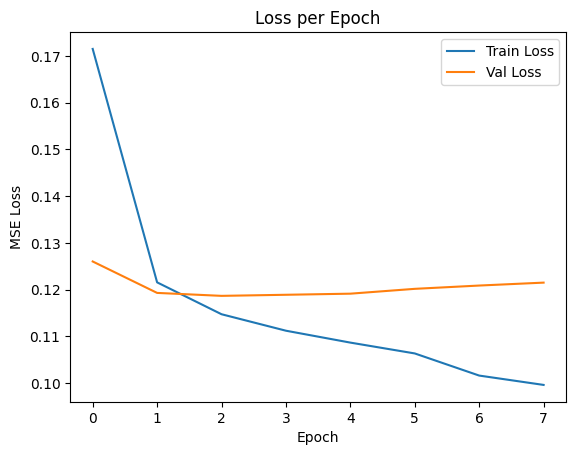

In [30]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

## Diagnosa Overfitting / Underfitting

Untuk mengevaluasi apakah model mengalami overfitting atau underfitting, dilakukan analisis terhadap nilai loss dan MAE pada data pelatihan dan validasi. Jika selisih nilai pada data validasi dan pelatihan cukup besar, itu bisa mengindikasikan overfitting.


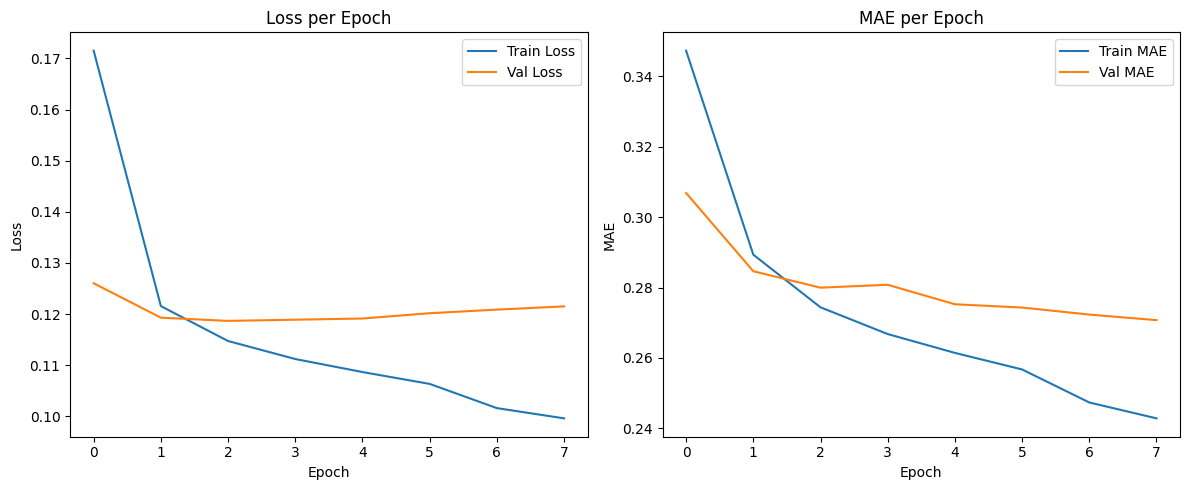

In [31]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluasi Model (Denormalisasi + RMSE/MAE Akhir)

- Melakukan prediksi pada data validasi.

- Mengembalikan hasil prediksi dan ground truth ke skala asli.

- Menghitung metrik RMSE dan MAE sebagai evaluasi performa.

In [32]:
# Prediksi pada data validasi
y_pred_scaled = model.predict([x_val[:, 0], x_val[:, 1]])
y_pred = scaler.inverse_transform(y_pred_scaled)

# Denormalisasi ground truth
y_true = scaler.inverse_transform(y_val_scaled.reshape(-1, 1))

# Hitung metrik evaluasi akhir
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"Final RMSE: {rmse:.4f}")
print(f"Final MAE: {mae:.4f}")

2770/2770 [==============================] - 3s 989us/step
Final RMSE: 3.4196
Final MAE: 2.7997


## Load Data & Fungsi Pembalik Encoding

- Membuat dictionary pembalik agar bisa mengubah ID numerik kembali ke user ID asli dan ISBN.

- Membuat mapping dari ISBN ke judul buku.

In [33]:
# Mapping pembalik untuk user dan buku
user_encoded2user = {v: k for k, v in user2user_encoded.items()}
book_encoded2book = {v: k for k, v in book2book_encoded.items()}

# Untuk mencari judul buku dari ISBN
isbn2title = dict(zip(books['ISBN'], books['Book-Title']))

## Membuat Fungsi Rekomendasi Buku

- Fungsi ini menerima user_id dan memprediksi rating untuk semua buku yang belum pernah dirating oleh user tersebut.

- Hasil prediksi diurutkan dan ditampilkan sebagai rekomendasi teratas.

In [34]:
def recommend_books_for_user(user_id, model, df, user2user_encoded, book_encoded2book, isbn2title, scaler, num_books, top_n=10):
    # Pastikan user tersedia dalam data training
    if user_id not in user2user_encoded:
        print("User tidak ditemukan dalam data latih.")
        return []

    # Encoding user ID
    encoded_user_id = user2user_encoded[user_id]

    # Buku-buku yang sudah diberi rating oleh user
    book_ids_already_rated = df[df['user'] == encoded_user_id]['book'].tolist()

    # Daftar kandidat buku yang belum dirating user
    candidate_books = np.setdiff1d(np.arange(num_books), book_ids_already_rated)

    # Input prediksi
    user_input_array = np.array([encoded_user_id] * len(candidate_books))
    book_input_array = candidate_books

    # Prediksi rating berskala 0–1, lalu dikembalikan ke skala asli
    pred_ratings_scaled = model.predict([user_input_array, book_input_array], verbose=0)
    pred_ratings = scaler.inverse_transform(pred_ratings_scaled).flatten()

    # Ambil Top-N buku dengan rating prediksi tertinggi, kecuali yang judulnya "Unknown Title"
    top_indices = np.argsort(pred_ratings)[::-1]
    recommendations = []

    for idx in top_indices:
        book_id = candidate_books[idx]
        rating = pred_ratings[idx]
        isbn = book_encoded2book[book_id]
        title = isbn2title.get(isbn, "Unknown Title")

        if title != "Unknown Title":
            recommendations.append((isbn, title, round(rating, 2)))

        if len(recommendations) == top_n:
            break

    return recommendations

## Contoh Penggunaan

Memilih satu user dari data dan menghasilkan rekomendasi untuk user tersebut, mencetak hasilnya dalam bentuk daftar buku dan prediksi rating.

In [35]:
# Mapping dari book encoded ke ISBN
book_encoded2book = {i: isbn for i, isbn in enumerate(book_ids)}

# Mapping dari ISBN ke judul buku
isbn2title = books_clean.set_index('ISBN')['Book-Title'].to_dict()

# Contoh rekomendasi untuk satu user
user_id_example = 276798  # Bisa ganti dengan user valid dari dataset
recs = recommend_books_for_user(
    user_id=user_id_example,
    model=model,
    df=df,
    user2user_encoded=user2user_encoded,
    book_encoded2book=book_encoded2book,
    isbn2title=isbn2title,
    scaler=scaler,
    num_books=num_books,
    top_n=10
)

# Tampilkan hasil rekomendasi
print(f"Rekomendasi buku untuk User-ID {user_id_example}:\n")
for i, (isbn, title, pred_rating) in enumerate(recs, 1):
    print(f"{i}. {title} (ISBN: {isbn}) — Prediksi Rating: {pred_rating}")

Rekomendasi buku untuk User-ID 276798:

1. Saving Grace (ISBN: 0345403339) — Prediksi Rating: 5.079999923706055
2. Living Juicy: Daily Morsels for Your Creative Soul (ISBN: 0890877033) — Prediksi Rating: 4.840000152587891
3. Odyssey: The Story of Odysseus (ISBN: 0451628055) — Prediksi Rating: 4.730000019073486
4. FAT!SO? : Because You Don't Have to Apologize for Your Size (ISBN: 0898159954) — Prediksi Rating: 4.710000038146973
5. Cows Of Our Planet (Far Side Series) (ISBN: 0836217012) — Prediksi Rating: 4.690000057220459
6. Hotel of the Saints (ISBN: 0684843102) — Prediksi Rating: 4.630000114440918
7. The Giving Tree (ISBN: 0060256656) — Prediksi Rating: 4.630000114440918
8. Almost blue (Stile libero) (ISBN: 8806143042) — Prediksi Rating: 4.590000152587891
9. I Just Forgot (A Little Critter Book) (ISBN: 0307119750) — Prediksi Rating: 4.570000171661377
10. It's Not About the Bike: My Journey Back to Life (ISBN: 0399146113) — Prediksi Rating: 4.550000190734863


## Kesimpulan & Insight Akhir

1. **Sistem rekomendasi berhasil dibangun** menggunakan pendekatan collaborative filtering berbasis embedding neural network.
2. **Model menunjukkan performa yang memadai**, dengan RMSE 3.4196 dan MAE 2.7997.
3. **Rekomendasi yang dihasilkan dipersonalisasi** berdasarkan interaksi historis pengguna dan buku.
4. **Sistem membantu pengguna menemukan bacaan baru** tanpa eksplorasi manual.
5. **Problem Statement berhasil dijawab**:
   - Sistem dapat memprediksi dan merekomendasikan buku yang relevan.
   - Memberikan nilai tambah dalam menjelajahi buku baru.
6. **Potensi pengembangan selanjutnya**:
   - Integrasi metadata buku (judul, genre, penulis).
   - Penerapan model hybrid (collaborative + content-based).
   - Eksperimen dengan model advanced seperti Neural Collaborative Filtering (NCF).